# Pairs Trading - Seleção de Portfólios Ótimos de Pares

**Autores: Alexandre Fernandes Theoharidis, Débora Darin, Nelly Pires Colnaghi e Rafael Couto**

O presente código foi desenvolvido com o intuito de selecionar portfólios ótimos formados por pares de ações estruturadas segundo a lógica de pairs trading. Nesse sentido, estende o primeiro notebook ao utilizar os retornos dos pares para composição de portfólios ótimos e analisar detalhadamente o desempenho dos mesmos.

No que tange à otimização, optou-se pelo modelo de Markowitz dinâmico. Desse modo, convencionou-se a adoção de uma janela de 126 dias úteis (6 meses) entre datas de rebalanceamento do portfólio. Nessas datas, com base em um histórico de retornos de 504 dias úteis (2 anos), executa-se o modelo de Markowitz, maximizando o índice de Sharpe do portfólio, sujeito a restrições associadas aos pesos dos pares, que devem variar entre -100% e 100% e somar 100%. A escolha desses limites sustenta-se na ideia de que pesos negativos são admissíveis nesse contexto, pois simplesmente representam a inversão das posições nas ações dos pares com tais pesos. As bandas, delimitadas por -100% e 100%, foram especificadas de tal modo a controlar a exposição bruta total (soma das posições long com as posições short, em valor absoluto) do portfólio. 

Na última seção do código, os retornos do portfólio ótimo são submetidos a uma análise de performance completa. Nesse sentido, adotamos uma abordagem de análise dos retornos fora da amostra (out of the sample). Com esse propósito, por meio da estratégia de rebalanceamento descrita anteriormente, os retornos do portfólio foram calculados usando pesos fixos no início de cada período entre datas de rebalanceamento. Como esses pesos foram estimados no primeiro dia desse período a partir dos dados históricos até essa data, torna-se factível verificar a performance da estratégia e do modelo de otimização em períodos futuros (fora da amostra).

Nesse contexto, para fins de avaliação da performance, inicialmente são calculadas estatísticas descritivas da distribuição dos retornos, de tal modo a caracterizá-la para compreensão de seu intervalo de variação típico e para identificação de assimetrias e de excesso de curtose. Posteriormente, são computadas métricas de desempenho, como Sharpe, Ômega e Sharpe Generalizado, bem como medidas de risco clássicas, incluindo VaR e CVaR. Gráficos para ilustração do retorno e da volatilidade ao decorrer do tempo são plotados ao final do trabalho.

Os resultados apresentados abaixo mostram que, no período analisado, a estratégia foi exitosa, entregando retornos líquidos de custos consistentemente positivos fora da amostra. Ademais, os retornos foram suficientes para remunerar o risco e superar o CDI, benchmark tipicamente empregado por fundos long-short. A escolha desse benchmark é apropriada porque, se tratando de uma estratégia conceitualmente market neutral, deve apresentar beta virtualmente nulo e, pelo CAPM, deveria gerar retornos iguais à taxa livre de risco. Qualquer retorno excedente representa geração de alfa, portanto. Cabe enfatizar que essa escolha é sustentada pela correlação histórica virtualmente nula contra o Ibovespa, confirmando que se trata de uma estratégia market neutral.

Concomitantemente, a análise de risco mostra que a estratégia possui níveis de volatilidade controlados, que oscilam entre 4% a.a. e 16% a.a. com média de 8% a.a., patamares esses inferiores aos tipicamente observados em investimentos em renda variável devido ao uso simultâneo de posições long e short que reduzem a exposição líquida do portfólio. A análise também permite depreender que a estratégia possui um caráter de total return, visto que consegue performar bem em diversos cenários, mostrando resiliência aos diversos períodos de turbulência existentes no histórico de dados coletado para o estudo. Em particular, na crise recente acarretada pela pandemia de Covid-19, houve um aumento na volatilidade dos retornos, porém a estratégia continuou gerando ganhos expressivos, possivelmente se aproveitando de distorções relativas nos preços dos ativos que tipicamente se formam em períodos de crise, quando os mercados financeiros ganham doses de irracionalidade.

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.neighbors import KernelDensity

## Parâmetros

In [2]:
str_dir = 'C:/Users/Alexandre/Desktop/Quant_Fin/'
str_Nome_Plan_Spreads = 'Spreads'
str_Nome_Plan_ADF = 'ADF'
str_Nome_Plan_Betas = 'Betas'
str_plan_bd_stocks = 'BD_Stocks_v6'
str_plan_indices = 'Indices'
str_retornos_pares = 'Retornos_Pares'

In [3]:
alfa = 0.01 # Nível de significância utilizado nos testes de hipótese 
janela_dados = 252 # tamanho da janela de dados utilizada para estimação dos modelos
janela_coint = 5 # janela de dias que será analisada para determinação da cointegração das ações de um par
cost = 0.0005 # custo de execução 
delta_beta_lim = 0 # variável para reduzir a frequência de ajustes de posição
hist = 504 # histórico de dados usado na otimização
janela = 126 # período entre datas de rebalanceamento

## Funções Exportadas do Primeiro Notebook

### Função para Indicar a Posição do Spread Relativamente ao Threshold

In [4]:
## A função retorna a posição onde o spread se localiza, em relação ao threshold. 
## Os quatro níveis são:
## Limite superior de cima: resultado = 3
## Limite superior entre as bandas: resultado = 2
## Limite inferior entre as bandas: resultado = 1
### Limite inferior de baixo: resultado = 0

def intervalos(df_spread, janela_dados, th):
    
    avg_spread = df_spread.rolling(window = janela_dados).mean()
    vol_spread = df_spread.rolling(window = janela_dados).std(ddof = 1)
                        
    lim_sup = avg_spread + th*vol_spread
    lim_inf = avg_spread - th*vol_spread
    
    resultado = (df_spread > lim_sup)*1 + (df_spread > avg_spread)*1 + (df_spread > lim_inf)*1

    return resultado

### Função para Realização do Backtest

In [5]:
def backtest_KF(log_price1, log_price2, df_spread, df_interv, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    lag = 1
    #inicio_est = 2 # começa 2 para frente pois iremos aplicar um shift de 2 dias
    #fim_est = janela_dados + 2 # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    inicio_est = lag # começa lag para frente pois iremos aplicar um shift de lag dias
    fim_est = janela_dados + lag # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # 1 se o par foi aberto quando o spread estava na região superior de fora
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-lag,0]
    beta1 = beta1_ant
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1 - 1) - (fim_est - janela_coint - 1) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint-(lag-1), fim_est-(lag-1)), 0]) == True:
            
            # Acompanha a variação do beta de um dia para o outro para ajustar a posição de acordo
            # com a variação do beta
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-lag,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-lag,0]
               
            # Caso 1: spread na parte superior de fora da banda
            if df_interv.iloc[fim_est-lag,0] == 3:
                    
                # Caso 1.1: sem posição em aberto --> abre posição
                if par_aberto == False:
                    
                    beta1 = df_beta1.iloc[fim_est-lag,0]
                    par_aberto = True
                    pos_aberto = 1
                    
                # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                    
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                    
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
    
            # Caso 2: spread na parte superior de dentro da banda
            if df_interv.iloc[fim_est-lag,0] == 2:
                
                # Caso 2.1: sem posição em aberto --> mantém
                if par_aberto == False:
                        
                    par_aberto = False
                    
                # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                        
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                
            # Caso 3: spread na parte inferior de dentro da banda
            if df_interv.iloc[fim_est-lag,0] == 1:
                    
                # Caso 3.1: sem posição em aberto --> mantém
                if par_aberto == False:
                        
                    par_aberto = False
                    
                # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                if par_aberto == True and pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                    
                # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                if par_aberto == True and pos_aberto == -1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
            # Caso 4: spread na parte inferior de fora da banda
            if df_interv.iloc[fim_est-lag,0] == 0:
        
                # Caso 4.1: sem posição em aberto --> abre
                if par_aberto == False:
                        
                    beta1 = df_beta1.iloc[fim_est-2,0]
                    par_aberto = True
                    pos_aberto = -1
                    
                # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                if par_aberto == True and pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                    
                # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                if par_aberto == True and pos_aberto == -1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2 
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

## Importação dos Dados

In [6]:
# Leitura das planilhas com os dados necessários para otimização

# Preços dos ativos
df_prices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_bd_stocks + '.csv', sep=';')
df_prices.index = pd.to_datetime(df_prices['Dates'])
df_prices = df_prices.drop(columns=['Dates'])
df_prices = df_prices.dropna()
df_log_prices = np.log(df_prices)

# Índices
df_indices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_indices + '.csv', sep=';')
df_indices.index = pd.to_datetime(df_indices['Dates'])
df_indices = df_indices.drop(columns=['Dates'])
df_indices = df_indices.dropna()

# Retornos dos pares selecionados
df_retornos_pares = pd.read_csv(filepath_or_buffer = str_dir + str_retornos_pares + '.csv', sep=';')
df_retornos_pares.index = pd.to_datetime(df_retornos_pares['Dates'])
df_retornos_pares = df_retornos_pares.drop(columns=['Dates'])
df_retornos_pares = df_retornos_pares.dropna(how='all')
df_retornos_pares = df_retornos_pares.fillna(0)

## Otimização do Portfólio de Pares

In [7]:
# Função para determinação do portfólio de máximo Sharpe
# Restrição 1: soma dos pesos dos pares = 1
# Restrição 2: peso dos pares entre -1 e 1 (ausência de alavancagem)
# Obs: pesos negativos são permitidos porque, caso ocorram, somente significam que as ações
#   do par devem ser invertidas

def opt_port_sharpe(mu, cov, rf):
    
    w0 = np.array([1/mu.shape[0]]*mu.shape[0])
    
    max_sharpe = lambda x : -((x.dot(mu) - rf) / np.sqrt(x.dot(cov).dot(x)))
    eq_cons = ({'type': 'eq', 'fun': lambda x: x.sum() - 1})
    
    res = opt.minimize(max_sharpe, w0, 
                       method = 'SLSQP',
                       bounds = np.array([-np.ones(mu.shape[0]),np.ones(mu.shape[0])]).T, 
                       constraints = eq_cons)
    
    w = pd.Series(index = mu.index, data = res.x)

    return w

In [8]:
# A rotina abaixo executa a otimização dinâmica de portfólio

i = hist
df_fundo_log_retorno = pd.DataFrame()
df_w = pd.DataFrame()
qty_pairs = len(df_retornos_pares)

while i < len(df_retornos_pares):
    
    # Esse if ajusta a janela na última iteração para não extrapolar o histórico de dados
    if i + janela > len(df_retornos_pares):
        janela = len(df_retornos_pares) - i
    
    rf = np.mean(df_indices['BZDIOVRA Index'].iloc[(i-hist):i])

    df_ret_aux = df_retornos_pares.iloc[(i-hist):i,:]
    mu = np.mean(df_ret_aux)*252
    cov = df_ret_aux.cov()*252
    w_max = np.array(opt_port_sharpe(mu,cov,rf))
    r = np.array(df_retornos_pares.iloc[i:(i+janela),:])
    rp = w_max.dot(r.T)
    
    if i == hist:
        df_fundo_log_retorno = pd.DataFrame(data = rp, index = df_retornos_pares.index[i:(i+janela)])
        df_w = pd.DataFrame(w_max.T)
    else:
        df_fundo_log_retorno = pd.concat([df_fundo_log_retorno, 
                                      pd.DataFrame(data = rp, index = df_retornos_pares.index[i:(i+janela)])], axis = 0)    
        df_w = pd.concat([df_w, pd.DataFrame(w_max.T)], axis = 1)
    
    i = i + janela
    
df_fundo_retorno = np.exp(df_fundo_log_retorno) - 1
df_fundo_retorno.columns = ['Fundo_Retorno']

## Análise de Performance

### Caracterização da Distribuição dos Retornos do Fundo

In [9]:
# Retornos do CDI, usado como taxa livre de risco
# Séries de datas são compatibilizadas para garantir a execução correta da análise
df_cdi_retorno = pd.DataFrame(df_indices['BZDIOVRA Index'])
df_cdi_retorno.columns = ['CDI_Retorno']
df_cdi_retorno = df_cdi_retorno[df_cdi_retorno.index.isin(df_fundo_retorno.index)]
df_cdi_log_retorno = np.log(1+df_cdi_retorno)
df_cdi_log_retorno.columns = ['CDI_Log_Retorno']
df_cdi_retorno_acum = np.exp(np.log(1+df_cdi_retorno).cumsum())-1
df_cdi_retorno_acum.columns = ['CDI_Retorno_Acum']

In [10]:
# Retornos do portfólio ótimo
# Séries de datas são compatibilizadas para garantir a execução correta da análise
df_fundo_retorno = df_fundo_retorno[df_fundo_retorno.index.isin(df_cdi_retorno.index)]
df_fundo_log_retorno = np.log(1+df_fundo_retorno)
df_fundo_log_retorno_acum = df_fundo_log_retorno.cumsum()
df_fundo_retorno_acum = np.exp(df_fundo_log_retorno_acum)-1

In [11]:
# Principais estatísticas (retornos discretos diários)
fundo_retorno_media = np.mean(np.array(df_fundo_retorno))
print("Média dos retornos:")
print(fundo_retorno_media)
fundo_retorno_std = np.std(np.array(df_fundo_retorno), ddof = 1)
print("Desvio padrão dos retornos:")
print(fundo_retorno_std)
fundo_retorno_min = np.min(np.array(df_fundo_retorno))
print("Retorno mínimo:")
print(fundo_retorno_min)
fundo_retorno_q1 = np.percentile(np.array(df_fundo_retorno), 25, axis = 0)
print("Primeiro quartil:")
print(fundo_retorno_q1)
fundo_retorno_q2 = np.percentile(np.array(df_fundo_retorno), 50, axis = 0)
print("Mediana:")
print(fundo_retorno_q2)
fundo_retorno_q3 = np.percentile(np.array(df_fundo_retorno), 75, axis = 0)
print("Terceiro quartil:")
print(fundo_retorno_q3)
fundo_retorno_max = np.max(np.array(df_fundo_retorno))
print("Retorno máximo:")
print(fundo_retorno_max)
fundo_retorno_range = fundo_retorno_max - fundo_retorno_min
print("Amplitude do intervalo de retornos:")
print(fundo_retorno_range)
fundo_retorno_skew = sp.stats.skew(np.array(df_fundo_retorno))
print("Assimetria:")
print(fundo_retorno_skew)
fundo_retorno_exc_kurt = sp.stats.kurtosis(np.array(df_fundo_retorno))
print("Excesso de curtose:")
print(fundo_retorno_exc_kurt)

Média dos retornos:
0.0004986938529268179
Desvio padrão dos retornos:
0.004901735126348638
Retorno mínimo:
-0.04760129498452814
Primeiro quartil:
[-0.00194785]
Mediana:
[0.00010444]
Terceiro quartil:
[0.00279473]
Retorno máximo:
0.025063002719011518
Amplitude do intervalo de retornos:
0.07266429770353966
Assimetria:
[-0.23188892]
Excesso de curtose:
[6.44376813]


In [12]:
# Volatilidade histórica anualizada
vol_hist = np.std(np.array(df_fundo_retorno), ddof = 1)*np.sqrt(252)
print('Volatilidade histórica anualizada:')
print(vol_hist)

# Volatilidade nos últimos 12 meses
vol_12m = np.std(np.array(df_fundo_retorno.tail(252)), ddof = 1)*np.sqrt(252)
print('Volatilidade nos últimos 12 meses:')
print(vol_12m)

# Sharpe para uma janela de 12 meses
fundo_retorno_media_12m = np.mean(np.array(df_fundo_retorno.tail(252)))
cdi_retorno_media_12m = np.mean(np.array(df_cdi_retorno.tail(252)))
fundo_sharpe_12m = (((1+fundo_retorno_media_12m)**252-1) - ((1+cdi_retorno_media_12m)**252-1)) / vol_12m
print("Sharpe nos últimos 12 meses:")
print(fundo_sharpe_12m)

# Sharpe histórico
fundo_retorno_media_hist = np.mean(np.array(df_fundo_retorno))
cdi_retorno_media_hist = np.mean(np.array(df_cdi_retorno))
fundo_sharpe_hist = (((1+fundo_retorno_media_hist)**252-1) - ((1+cdi_retorno_media_hist)**252-1)) / vol_hist
print("Sharpe histórico:")
print(fundo_sharpe_hist)

Volatilidade histórica anualizada:
0.0778126328221696
Volatilidade nos últimos 12 meses:
0.09339729154020317
Sharpe nos últimos 12 meses:
2.5667721083413224
Sharpe histórico:
0.5083945265140501


## Métricas de Retorno e Risco

### Máximo Drawdown

In [13]:
# Função para calcular o máximo drawdown e encontrar as datas
def MaxDD(r_cum):
    max2here = r_cum.expanding(min_periods=1).max()
    dd2here = (1+r_cum)/(1+max2here) - 1.0
    return dd2here.min(), dd2here.idxmax(), dd2here.idxmin()

In [14]:
# Cálculo do Máximo Drawdown
MaxDD(df_fundo_retorno_acum)

(Fundo_Retorno   -0.09829
 dtype: float64,
 Fundo_Retorno   2010-11-25
 dtype: datetime64[ns],
 Fundo_Retorno   2015-08-05
 dtype: datetime64[ns])

### VaR

In [15]:
# VaR diário calculado com base nos dados históricos
def VaR_Hist(r_port, alfa):
    n = int(np.floor(len(r_port)*alfa))
    r_port_sorted = np.sort(r_port)
    return r_port_sorted[n-1]

In [16]:
# VaR diário não paramétrico usando Kernel
def VaR_NonPar(r_port, alfa, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    res.columns = r_port.columns
    for j in range(0,cols):
        if not np.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            res.iloc[0,j]=x_plot[len(cum_dens[cum_dens<=alfa])-1]
    return res

In [17]:
VaR_Hist(df_fundo_retorno, 0.05)

array([0.00211243])

In [18]:
VaR_NonPar(df_fundo_retorno, 0.05, 1000)

,Fundo_Retorno
0,-0.00697


### CVaR

In [19]:
# CVaR diário calculado com base nos dados históricos
def CVaR_Hist(r_port, alfa):
    VaR = VaR_Hist(r_port, alfa)
    CVaR = np.mean(r_port[r_port<=VaR])
    return CVaR

In [20]:
# CVaR diário não paramétrico usando Kernel
def CVaR_NonPar(r_port, alfa, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    res.columns = r_port.columns
    for j in range(0,cols):
        if not np.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            res.iloc[0,j]=np.mean(x_plot[0:(len(cum_dens[cum_dens<=alfa])-1)])
    return res

In [21]:
CVaR_Hist(df_fundo_retorno, 0.05)

Fundo_Retorno   -0.001815
dtype: float64

In [22]:
CVaR_NonPar(df_fundo_retorno, 0.05, 1000)

,Fundo_Retorno
0,-0.011829


### Ômega - Keating e Shadwick (2002)

In [23]:
def Omega(r_port, threshold, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    for j in range(0,cols):
        if not np.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            x_plot_low = x_plot[x_plot<=threshold]
            x_plot_high = x_plot[x_plot>threshold]
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            try:
                int_low = sp.integrate.simps(cum_dens[x_plot<=threshold], x_plot_low)
                int_high = sp.integrate.simps(cum_dens[x_plot>threshold], x_plot_high)
                res.iloc[0,j]=((np.max(x_plot)-threshold)-int_high)/int_low
            except:
                res.iloc[0,j]=np.nan
    return res

In [24]:
Omega(df_fundo_retorno, np.mean(df_cdi_retorno)[0], 1000)

,0
0,1.160206


### Sharpe Generalizado - Zakamouline e Koekebakker (2009)

In [25]:
# Sharpe generalizado - Zakamouline e Koekebakker (2009)
def ASKSR(r_port, rf):
    avg = np.mean(r_port)
    var = np.var(r_port)
    skew = sp.stats.skew(r_port)
    kurt = sp.stats.kurtosis(r_port, fisher = False)
    alfa = 3*np.sqrt(3*kurt-4*skew**2-9)/(var*(3*kurt-5*skew**2-9))
    beta = 3*skew/(np.sqrt(var)*(3*kurt-5*skew**2-9))
    eta = avg - 3*skew*np.sqrt(var)/(3*kurt-4*skew**2-9)
    delta = 3*np.sqrt(var)*np.sqrt(3*kurt-5*skew**2-9)/(3*kurt-4*skew**2-9)
    phi = np.sqrt(alfa**2-beta**2)
    a = (beta+alfa*(eta-rf)/np.sqrt(delta**2+(eta-rf)**2))
    return np.sqrt(2*(a*(eta-rf)-delta*(phi-np.sqrt(alfa**2-(beta-a)**2))))

In [26]:
ASKSR(df_fundo_retorno, np.mean(df_cdi_retorno))

CDI_Retorno     NaN
Fundo_Retorno   NaN
dtype: float64

## Caracterização da Distribuição dos Retornos do Fundo

In [27]:
# Retornos positivos e negativos - Base Diária
fundo_pct_retornos_pos = df_fundo_retorno[df_fundo_retorno>0].count() / df_fundo_retorno.count()
fundo_pct_retornos_pos = np.array(fundo_pct_retornos_pos)
fundo_pct_retornos_neg = 1 - fundo_pct_retornos_pos
print('% Retornos Positivos:')
print(fundo_pct_retornos_pos)
print('% Retornos Negativos:')
print(fundo_pct_retornos_neg)

% Retornos Positivos:
[0.51958844]
% Retornos Negativos:
[0.48041156]


In [28]:
# Retornos acima e abaixo do benchmark - Base Diária
df_fundo_retorno_exc = pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index)    
df_fundo_retorno_exc.columns = ['Fundo_Retorno_Exc']
fundo_pct_retornos_exc_pos = df_fundo_retorno_exc[df_fundo_retorno_exc>0].count() / df_fundo_retorno_exc.count()
fundo_pct_retornos_exc_pos = np.array(fundo_pct_retornos_exc_pos)
fundo_pct_retornos_exc_neg = 1 - fundo_pct_retornos_exc_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_neg)

% Retornos Excedentes Positivos:
[0.46853977]
% Retornos Excedentes Negativos:
[0.53146023]


## Melhor / Pior Dia

In [29]:
# Melhor / Pior Dia
fundo_retorno_min = (np.min(np.array(df_fundo_retorno)))
print("Retorno Diário Mínimo:")
print(fundo_retorno_min)
dia_retorno_min = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_min].index)
print("Data de Ocorrência do Retorno Diário Mínimo:")
print(dia_retorno_min)

fundo_retorno_max = (np.max(np.array(df_fundo_retorno)))
print("Retorno Diário Máximo:")
print(fundo_retorno_max)
dia_retorno_max = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_max].index)
print("Data de Ocorrência do Retorno Diário Máximo:")
print(dia_retorno_max)

Retorno Diário Mínimo:
-0.04760129498452814
Data de Ocorrência do Retorno Diário Mínimo:
['2020-03-16T00:00:00.000000000']
Retorno Diário Máximo:
0.025063002719011518
Data de Ocorrência do Retorno Diário Máximo:
['2020-03-27T00:00:00.000000000']


## Correlações

In [30]:
df_ret_indices = pd.concat([df_indices['IBOV Index'], df_indices['IFMMIFMM Index']], axis = 1).pct_change()
df_ret_indices = df_ret_indices[df_ret_indices.index.isin(df_fundo_retorno.index)]
df_series = pd.concat([df_fundo_retorno, df_ret_indices], axis = 1)
df_series.corr()

,Fundo_Retorno,IBOV Index,IFMMIFMM Index
Fundo_Retorno,1.000000,0.012675,0.021468
IBOV Index,0.012675,1.000000,0.010503
IFMMIFMM Index,0.021468,0.010503,1.000000


## Gráficos

Text(0.5, 1.0, 'Retornos Acumulados Desde o Início do Fundo')

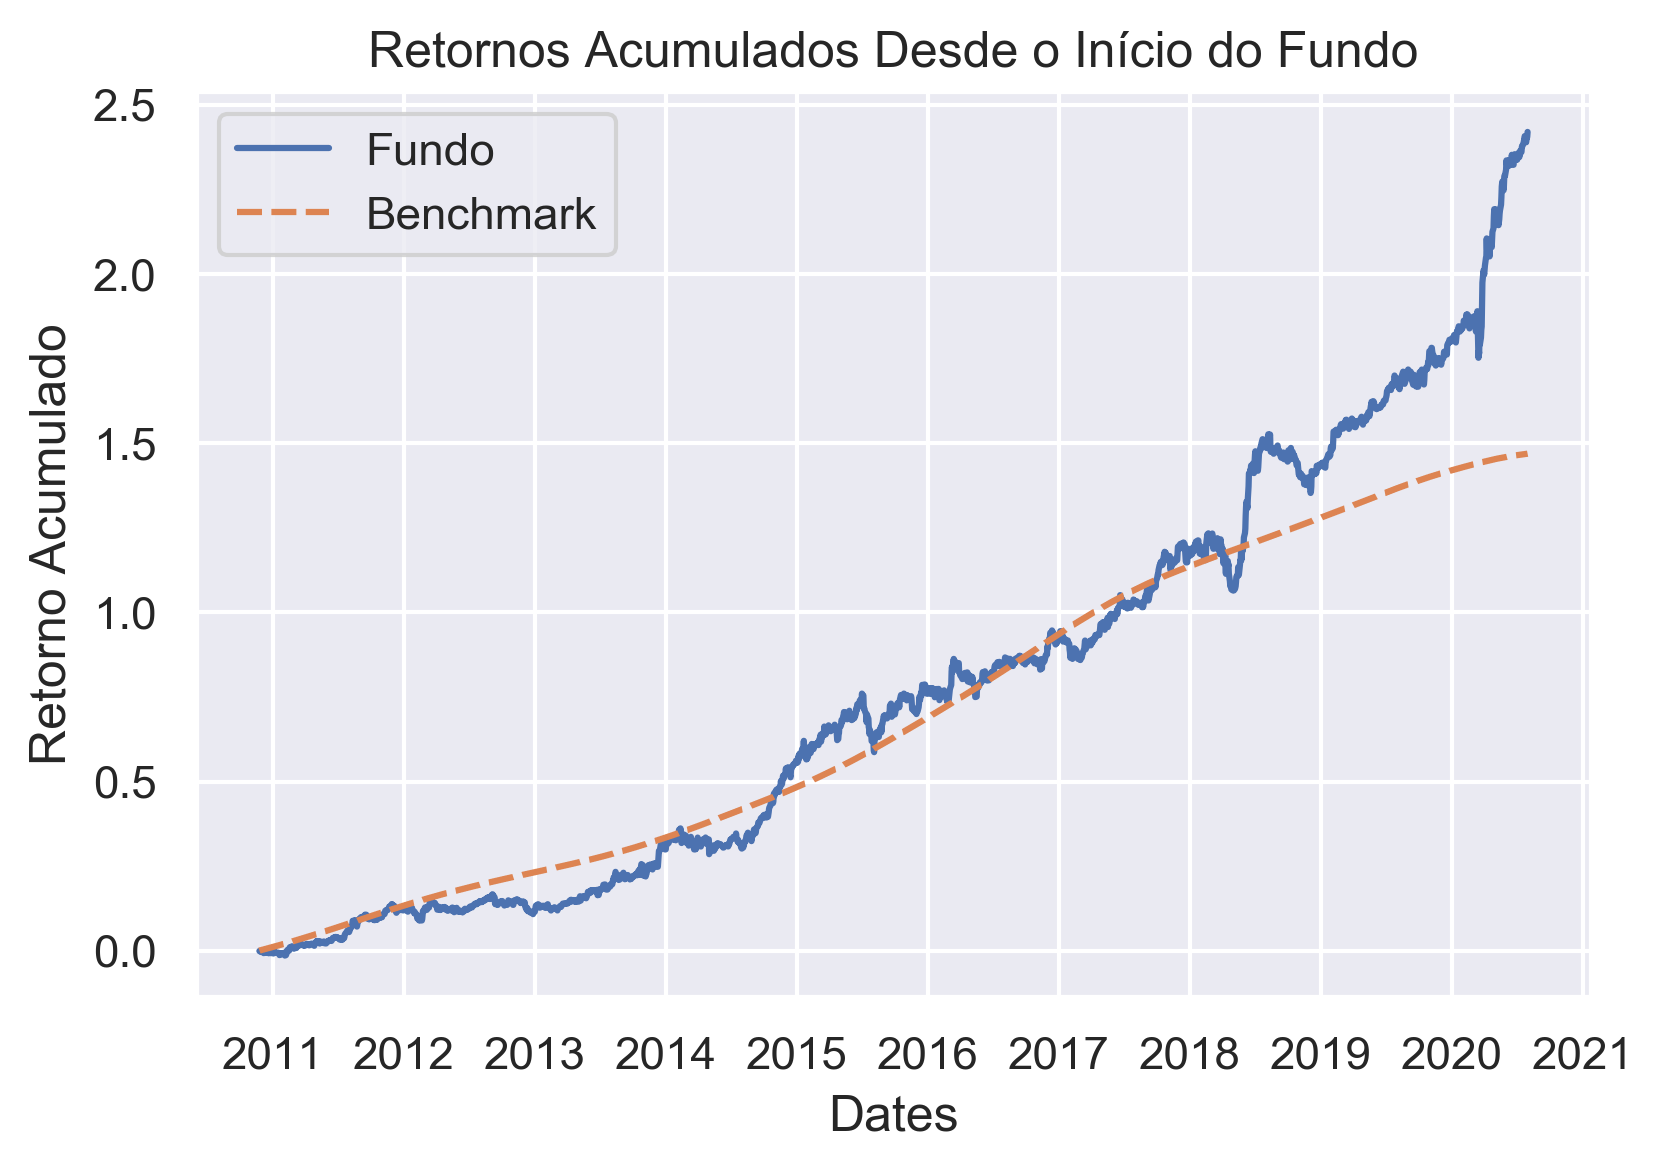

In [31]:
# Estilo dos gráficos
sns.set(color_codes = True)
plt.rcParams['figure.dpi'] = 300 # Resolução dos gráficos impressos no pdf (dpi)

# Gráfico dos retornos acumulados
df_bench_acum = df_cdi_retorno_acum  
    
df_retornos = pd.merge(df_fundo_retorno_acum, df_bench_acum, 
                    left_index = True, right_index = True, how = 'inner')
df_retornos.columns = ["Fundo", "Benchmark"]
ax = sns.lineplot(data = df_retornos)
ax.set_ylabel("Retorno Acumulado")
ax.set_title("Retornos Acumulados Desde o Início do Fundo")

Text(0.5, 1.0, 'Volatilidade em Janelas de 63 d.u.')

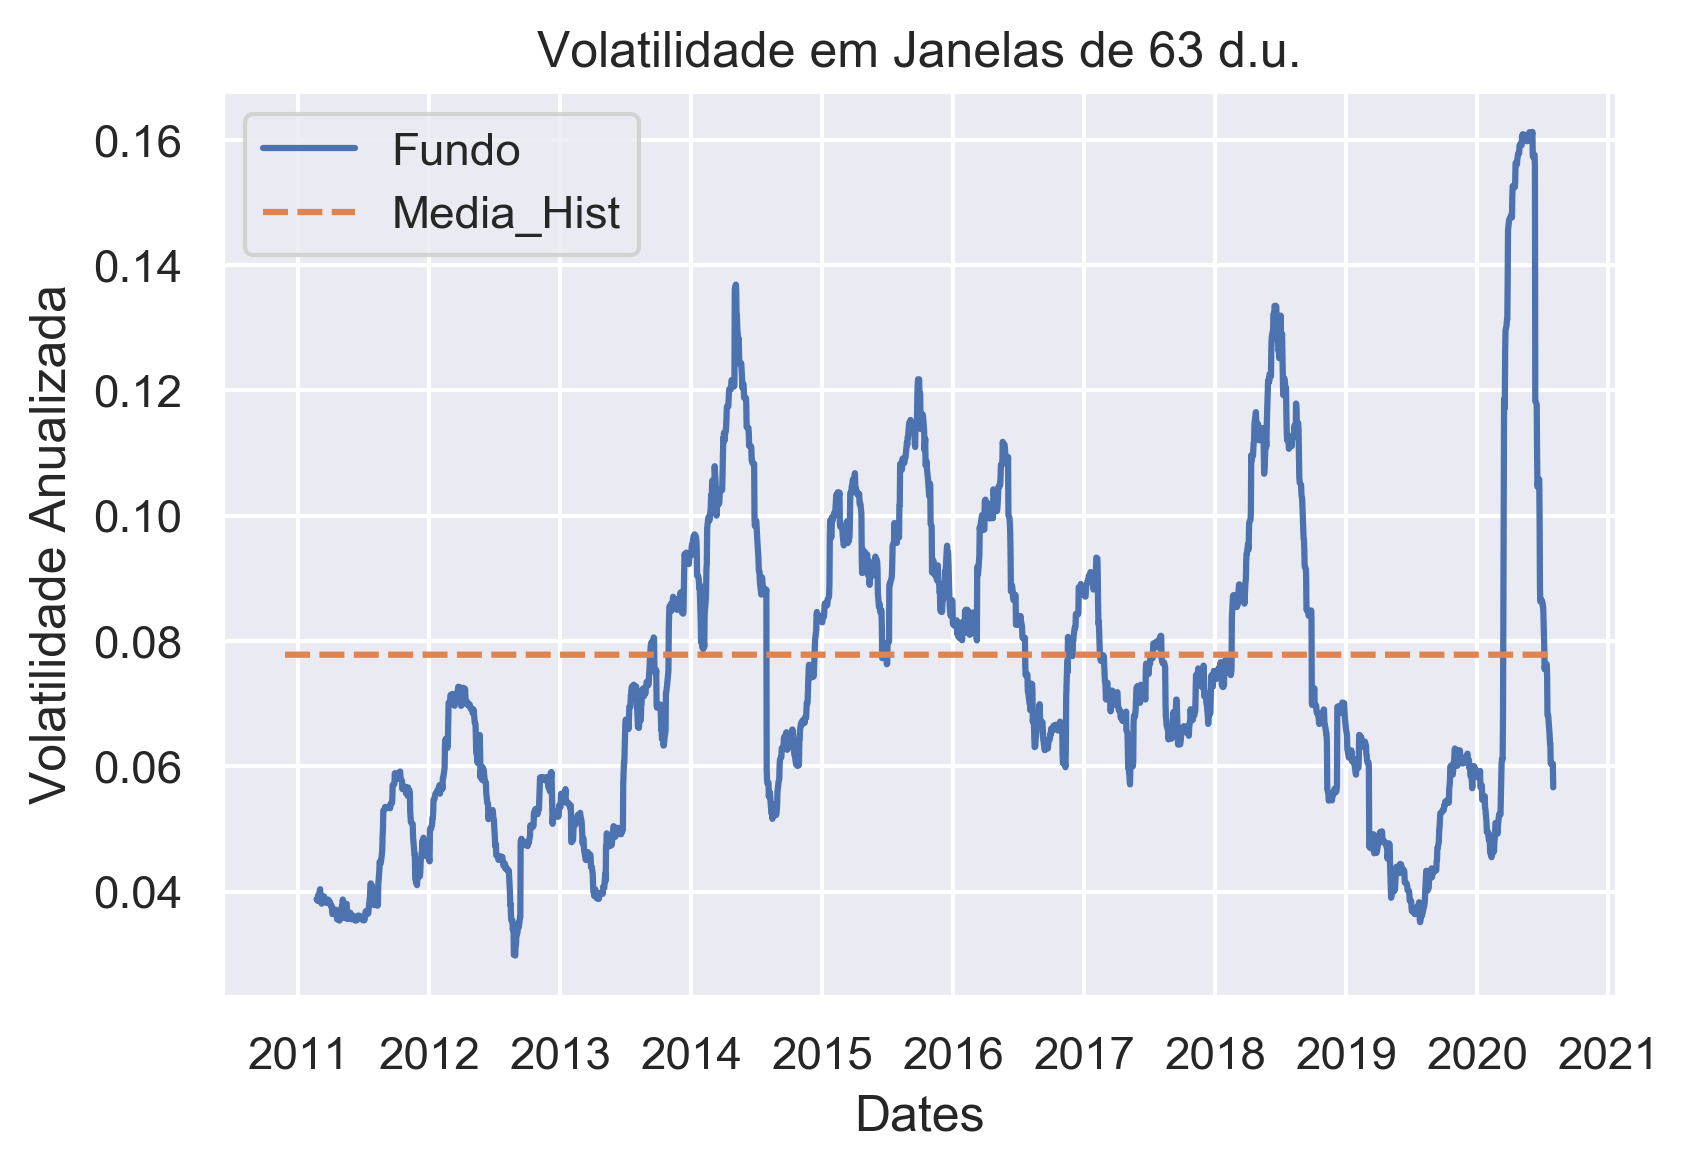

In [32]:
# Volatilidade em janelas móveis de 3 meses
du = 63
vol = df_fundo_retorno.rolling(du).std(ddof=1)*np.sqrt(252)
vol.columns = ["Fundo"]
vol["Media_Hist"] = np.repeat(vol_hist, vol.shape[0])
ax = sns.lineplot(data = vol)
ax.set_ylabel("Volatilidade Anualizada")
ax.set_title("Volatilidade em Janelas de " + str(du) + " d.u.")